In [1]:
import os

from dotenv import load_dotenv
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.runnables.graph_mermaid import draw_mermaid_png


In [2]:
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    max_tokens=None,
    timeout=None,
    max_retries=5
)

In [3]:
try:
    if api_key is not None:
        print("API key is loaded sucessfully")
except Exception as e:
    print(f"Erro {e}")

API key is loaded sucessfully


In [4]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

members = ["researcher", "coder"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_155442/1357076202.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/tmp/ipykernel_155442/1357076202.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [5]:
class Router(TypedDict):

    next: Literal[*options]


class State(MessagesState):
    
    next: str

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [6]:
research_agent = create_react_agent(llm, tools=[tavily_tool], prompt="You are a research. DO NOT do any math.")

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor"
    )

In [7]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [8]:
builder = StateGraph(State)
builder.set_entry_point("supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

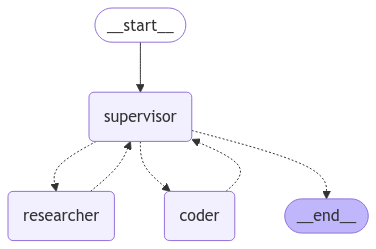

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:785a785a-b461-60c9-ed20-2a29230f9365',), {'agent': {'messages': [AIMessage(content="I can't perform calculations, but you can easily find the square root of 42 using a calculator or a math tool. If you need any other information or context about square roots, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 98, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-3098c0b5-3f12-4490-84f0-b9f8010b27ff-0', usage_metadata={'input_tokens': 98, 'output_tokens': 43, 'total_tokens': 141, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

Python REPL can execute arbitrary code. Use with caution.


(('coder:2c9bcc66-ce7a-e629-de3e-050fe69f92f1',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xh1YEIdIrkqVpZr3kfePjBnS', 'function': {'arguments': '{"code":"import math\\nmath.sqrt(42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 144, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ef777736-deb7-492a-bf98-4489baab2248-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nmath.sqrt(42)'}, 'id': 'call_xh1YEIdIrkqVpZr3kfePjBnS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 144, 'output_tokens': 2

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT